In [1]:
from glob import glob
import numpy as np
import pandas as pd
from pathlib import Path
import sys
from itertools import combinations, product
sys.path.append('../')

import matplotlib.pyplot as plt
from tqdm import tqdm
from astropy.table import Table, unique, join
import papermill as pm
from astropy.time import Time
from uvot import filter_colors
corr = __import__('11_corr')
from process_corr import load_df_prop, load_df_fit_samples, load_df_fit_values

In [2]:
from uvot import filters
from xrt import curves
from source_names_dict import source_names_dict, source_names_w_counterparts, source_names_readable, get_simbad_name_glob
from table_closest_srcreg import get_src_region_dict
from uvot import read_uvotsource, calc_uvot_flags, filters, filter_colors, filter_markers
from xrt import load_xrt, rename_xrt_cols, curves
from lightcurve import LightCurve

In [3]:
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

In [4]:
pd.set_option('display.max_rows', 20)

In [5]:
def line(x, m, c):
    return m*x+c

In [6]:
curve_energies = {'FULL' : '0.3 - 10.0',
                  'SOFT' : '0.3 - 1.5',
                  'HARD' : '1.5 - 10.0',
                  'HR'   : r'Ratio $\frac{(1.5 - 10.0)}{(0.3 - 1.5)}$'}

In [7]:
df_prop = load_df_prop()

100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [00:06<00:00, 182.79it/s]


In [8]:
df_prop.sort_values('N_bad', ascending=False)

,name,length,N_obs,N_bad,N_good,N_UL,simbad_name,xrt_curve,uvot_filter,include_bad,include_UL
1,tab_5_sig,352,352,338,14,342,M31_ULX-1,FULL,UVW1,True,False
4,tab_BAD,338,338,338,0,330,M31_ULX-1,FULL,UVW1,True,True
1,tab_5_sig,352,352,338,14,342,M31_ULX-1,FULL,UVW1,True,True
0,tab,353,353,338,15,342,M31_ULX-1,FULL,UVW1,True,True
0,tab,353,353,338,15,342,M31_ULX-1,FULL,UVW1,False,True
...,...,...,...,...,...,...,...,...,...,...,...
2,tab_UL,0,0,0,0,0,NAME_NGC_925_ULX-1,HARD,U,False,False
1,tab_5_sig,16,16,0,16,0,NAME_NGC_925_ULX-1,HARD,U,False,False
0,tab,16,16,0,16,0,NAME_NGC_925_ULX-1,HARD,U,False,False
7,tab_no_UL_no_bad,22,22,0,22,0,NAME_NGC_925_ULX-1,FULL,UVW2,True,True


In [9]:
df_fit_samples = load_df_fit_samples()

100%|███████████████████████████████████████████████████████████████████████████████| 1159/1159 [00:23<00:00, 49.15it/s]


In [10]:
df_fit_samples.head()

,r,m,c,simbad_name,xrt_curve,uvot_filter,include_bad,include_UL
0,0.063017,0.215876,4.580543,Holmberg_II_X-1,FULL,U,False,False
1,0.017448,0.057785,4.617781,Holmberg_II_X-1,FULL,U,False,False
2,0.125694,0.475514,4.539602,Holmberg_II_X-1,FULL,U,False,False
3,0.060582,0.212750,4.596326,Holmberg_II_X-1,FULL,U,False,False
4,0.059251,0.213772,4.580452,Holmberg_II_X-1,FULL,U,False,False


In [11]:
df_fs = df_fit_samples.set_index(['simbad_name','xrt_curve','uvot_filter','include_bad','include_UL'])

In [12]:
df_fs

r  \
simbad_name                   xrt_curve uvot_filter include_bad include_UL             
Holmberg_II_X-1               FULL      U           False       False       0.063017   
                                                                False       0.017448   
                                                                False       0.125694   
                                                                False       0.060582   
                                                                False       0.059251   
...                                                                              ...   
[SST2011]_J141939.39+564137.8 SOFT      UVM2        True        False       0.338158   
                                                                False       0.351061   
                                                                False       0.137112   
                                                                False       0.253237   
                                                                False       0.018749   

                                                                                   m  \
simbad_name                   xrt_curve uvot_filter include_bad include_UL             
Holmberg_II_X-1               FULL      U           False       False       0.215876   
                                                                False       0.057785   
                                                                False       0.475514   
                                                                False       0.212750   
                                                                False       0.213772   
...                                                                              ...   
[SST2011]_J141939.39+564137.8 SOFT      UVM2        True        False       4.431990   
                                                                False       3.259806   
                                                                False       0.901616   
                                                                False       1.403267   
                                                                False       0.148986   

                                                                                   c  
simbad_name                   xrt_curve uvot_filter include_bad include_UL            
Holmberg_II_X-1               FULL      U           False       False       4.580543  
                                                                False       4.617781  
                                                                False       4.539602  
                                                                False       4.596326  
                                                                False       4.580452  
...                                                                              ...  
[SST2011]_J141939.39+564137.8 SOFT      UVM2        True        False       0.115903  
                                                                False       0.103161  
                                                                False       0.112415  
                                                                False       0.104247  
                                                                False       0.114008  

[11590000 rows x 3 columns]

In [13]:
df = load_df_fit_values()

100%|███████████████████████████████████████████████████████████████████████████████| 1159/1159 [00:14<00:00, 77.72it/s]


In [29]:
df.to_csv('../tables/correlation_fit_values.csv', index=False)

In [14]:
df.head()

,simbad_name,xrt_curve,uvot_filter,include_bad,include_UL,r_mean,r_std,m_mean,m_std,c_mean,c_std
0,Holmberg_II_X-1,FULL,U,False,False,0.072601,0.043464,0.258043,0.154851,4.577567,0.025400
1,Holmberg_II_X-1,FULL,U,False,True,0.242112,0.049480,1.456759,0.540213,4.341777,0.104518
2,Holmberg_II_X-1,FULL,U,True,False,0.073178,0.043325,0.260076,0.154127,4.577213,0.025429
3,Holmberg_II_X-1,FULL,U,True,True,0.242648,0.048880,1.469303,0.536720,4.339227,0.103948
4,Holmberg_II_X-1,FULL,UVM2,False,False,0.059412,0.091786,0.186595,0.294732,1.968741,0.059692


In [15]:
df['xrt_curve'].unique()

array(['FULL', 'HARD', 'HR', 'SOFT'], dtype=object)

In [16]:
glob('../lightcurves/correlation_output/*NGC_300*/tables/*table_corr*')

['../lightcurves/correlation_output/NAME_NGC_300_ULX1/tables/NAME_NGC_300_ULX1,FULL,B,False,False,table_corr_mc.csv',
 '../lightcurves/correlation_output/NAME_NGC_300_ULX1/tables/NAME_NGC_300_ULX1,FULL,B,False,True,table_corr_mc.csv',
 '../lightcurves/correlation_output/NAME_NGC_300_ULX1/tables/NAME_NGC_300_ULX1,FULL,B,True,False,table_corr_mc.csv',
 '../lightcurves/correlation_output/NAME_NGC_300_ULX1/tables/NAME_NGC_300_ULX1,FULL,B,True,True,table_corr_mc.csv',
 '../lightcurves/correlation_output/NAME_NGC_300_ULX1/tables/NAME_NGC_300_ULX1,FULL,U,False,False,table_corr_mc.csv',
 '../lightcurves/correlation_output/NAME_NGC_300_ULX1/tables/NAME_NGC_300_ULX1,FULL,U,False,True,table_corr_mc.csv',
 '../lightcurves/correlation_output/NAME_NGC_300_ULX1/tables/NAME_NGC_300_ULX1,FULL,U,True,False,table_corr_mc.csv',
 '../lightcurves/correlation_output/NAME_NGC_300_ULX1/tables/NAME_NGC_300_ULX1,FULL,U,True,True,table_corr_mc.csv',
 '../lightcurves/correlation_output/NAME_NGC_300_ULX1/tables/NAM

In [17]:
#f'../lightcurves/correlation_output/*NGC_300*/tables/*{xrt_curve}*{subset}e*table_corr*'

In [18]:
nsig     = 2
r_mu     = df['r_mean'].mean()
r_std    = df['r_mean'].std()
r_sig_up = r_mu + nsig*r_std
r_sig_lo = r_mu - nsig*r_std


#df['nsig'] = abs((df['r_mean'] - r_mu) / r_std)
df['r_nsig'] = df['r_mean'] / df['r_std']
df['m_nsig'] = df['m_mean'] / df['m_std']


In [19]:
".",",","o",

('.', ',', 'o')

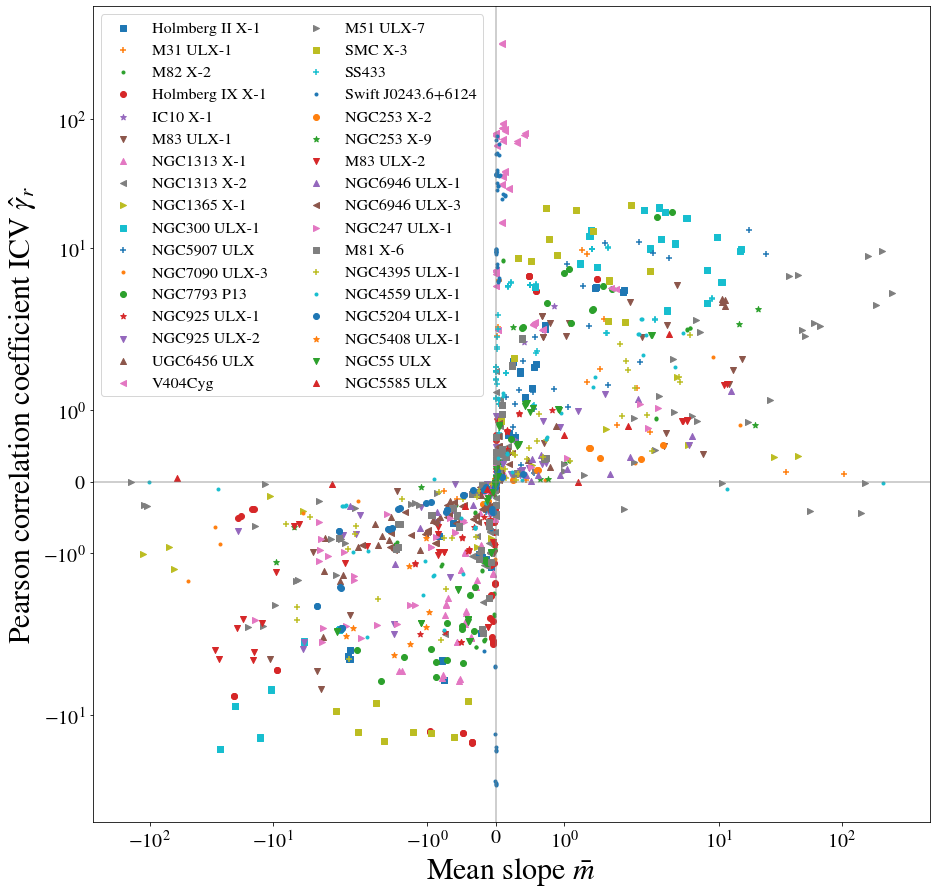

In [20]:
import itertools
marker = itertools.cycle((',', '+', '.', 'o', '*',"v","^","<",">")) 
plt.figure(figsize=(15,15), facecolor='white')
plt.axvline(0, color='grey', alpha=0.5)
plt.axhline(0, color='grey', alpha=0.5)
for i, s in enumerate(df['simbad_name'].unique()):
    sub = df[df['simbad_name'] == s]
    plt.scatter(sub['m_mean'], sub['r_nsig'], marker=next(marker), label=source_names_readable[s])
plt.xscale('symlog')
plt.yscale('symlog')
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel(r'Mean slope $\bar{m}$', size=30)
plt.ylabel(r'Pearson correlation coefficient ICV $\hat{\gamma}_{r}$', size=30)
plt.legend(ncol=2, loc='upper left', prop={'size': 16})
plt.savefig('../figures/all_correlations_m_mean_gamma_r.pdf', bbox_inches='tight')
plt.savefig('../figures/all_correlations_m_mean_gamma_r.png', bbox_inches='tight')

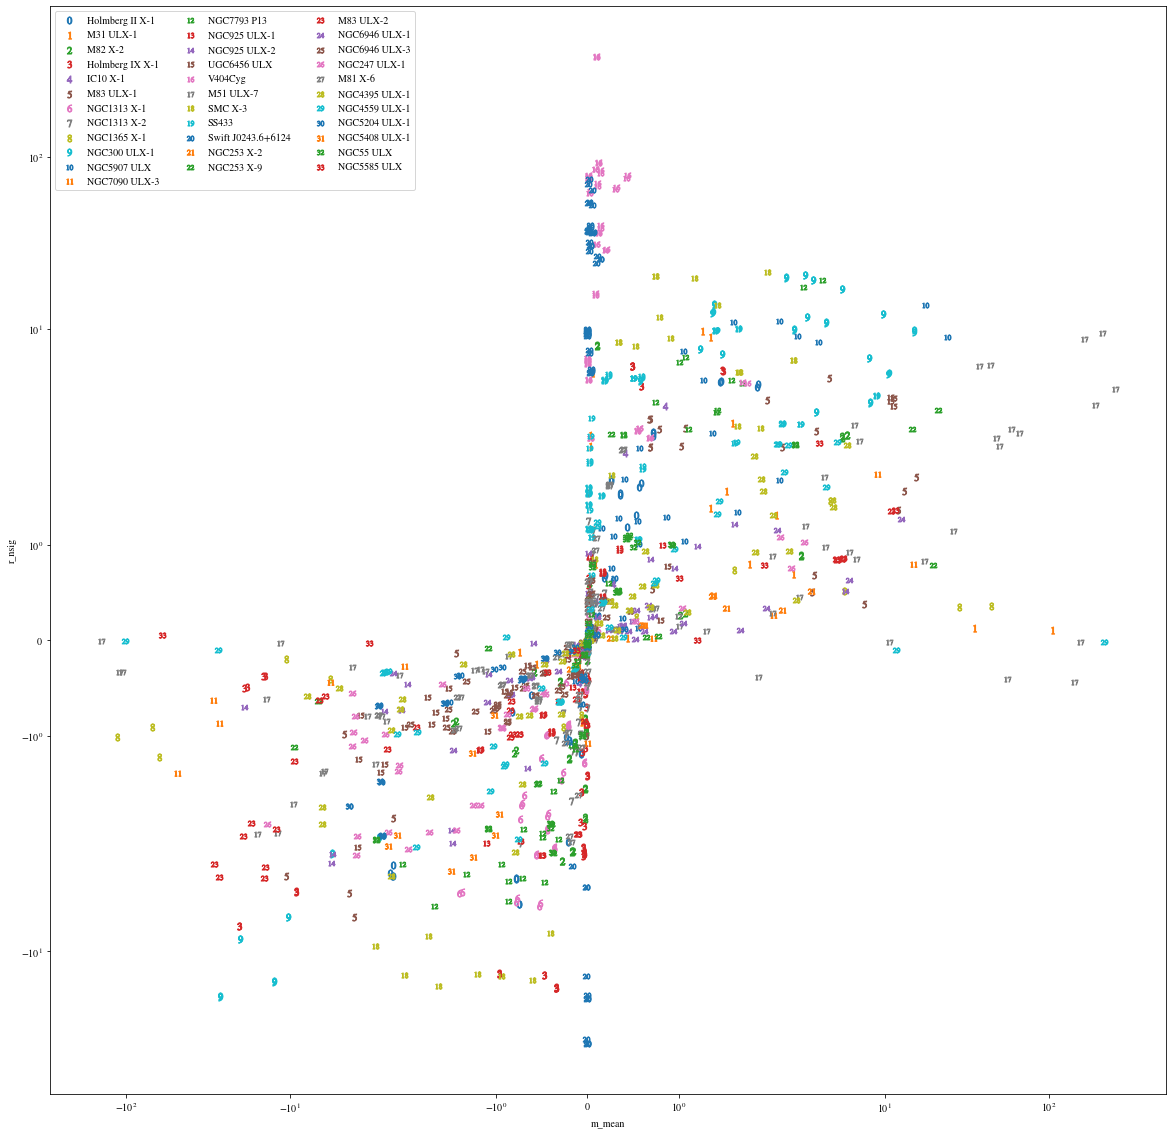

In [21]:
exclude = ['SWIFT_J0243.6+6124', 'NOVA_Cyg_1989', 'SMC_X-3']
exclude = []

plt.figure(figsize=(20,20), facecolor='white')
for i, s in enumerate(df['simbad_name'].unique()):
    if s in exclude:
        continue
    sub = df[df['simbad_name'] == s]
    plt.scatter(sub['m_mean'], sub['r_nsig'], marker=f'${i}$', label=source_names_readable[s], s=50)
    #plt.text(sub['m_mean'], sub['r_nsig'], s=s)
    #plt.errorbar(sub['m_mean'], sub['r_mean'], xerr=sub['m_std'], yerr=sub['r_std'], marker=f'${i}$', label=s, markersize=10)
plt.xlabel('m_mean')
plt.ylabel('r_nsig')

plt.xscale('symlog')
plt.yscale('symlog')

#plt.ylim(-5,5)
#plt.xlim(-10,10)
plt.legend(ncol=3, loc='upper left')
#plt.ylim(-10,10)

In [22]:
#sub_nsig = df[(df['r_mean'] > r_sig_up) | (df['r_mean'] < r_sig_lo)]
sub_nsig = df[df['r_nsig'] > 3]

In [23]:
df_prop_tab_3_sig = df_prop[df_prop['name'] == 'tab_3_sig']

In [24]:
df_3_sig_merge = pd.merge(sub_nsig, df_prop_tab_3_sig, on=['simbad_name','xrt_curve','uvot_filter','include_bad','include_UL'])
df_3_sig_merge

,simbad_name,xrt_curve,uvot_filter,include_bad,include_UL,r_mean,r_std,m_mean,m_std,c_mean,c_std,r_nsig,m_nsig,name,length,N_obs,N_bad,N_good,N_UL


In [25]:
df[df['simbad_name'] == 'NAME_NGC_300_ULX1']

,simbad_name,xrt_curve,uvot_filter,include_bad,include_UL,r_mean,r_std,m_mean,m_std,c_mean,c_std,r_nsig,m_nsig
297,NAME_NGC_300_ULX1,FULL,B,False,False,-0.484216,0.026249,-26.618599,2.064844,8.424631,0.142387,-18.447006,-12.891334
298,NAME_NGC_300_ULX1,FULL,B,False,True,0.128007,0.034183,8.093056,2.209138,4.165077,0.235996,3.744780,3.663445
299,NAME_NGC_300_ULX1,FULL,B,True,False,-0.484613,0.026561,-26.644561,2.082980,8.426033,0.146113,-18.245154,-12.791559
300,NAME_NGC_300_ULX1,FULL,B,True,True,0.128660,0.034536,8.126526,2.237343,4.161476,0.237229,3.725435,3.632221
301,NAME_NGC_300_ULX1,FULL,U,False,False,0.513743,0.042160,9.777822,0.945965,1.801510,0.049828,12.185451,10.336348
...,...,...,...,...,...,...,...,...,...,...,...,...,...
340,NAME_NGC_300_ULX1,SOFT,UVW1,True,False,0.469984,0.043710,4.410515,0.443393,0.584155,0.005444,10.752225,9.947201
341,NAME_NGC_300_ULX1,SOFT,UVW2,False,False,0.630613,0.030518,3.288971,0.231824,0.386531,0.003939,20.663421,14.187371
342,NAME_NGC_300_ULX1,SOFT,UVW2,True,False,0.630304,0.030622,3.285474,0.228276,0.386424,0.003908,20.583133,14.392539
343,NAME_NGC_300_ULX1,SOFT,V,False,False,-0.182503,0.028869,-10.367156,1.781855,3.107706,0.032509,-6.321661,-5.818181


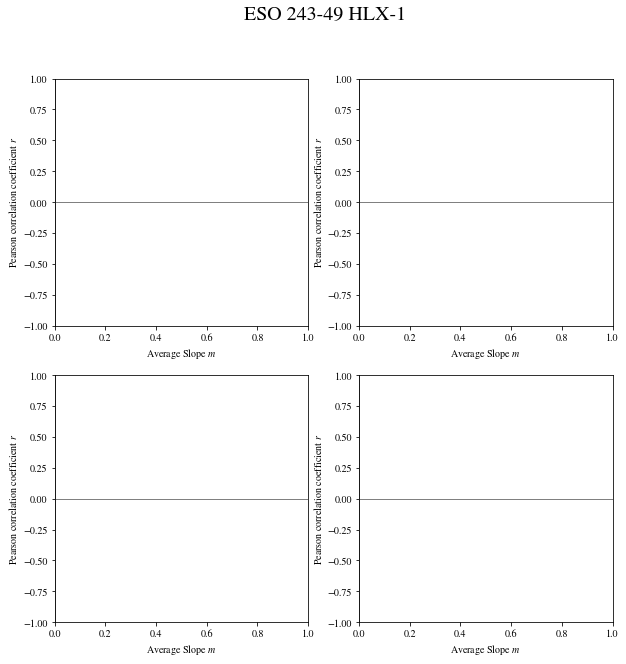

../lightcurves/correlation_output/NAME_Holmberg_IX_X-1/tables/NAME_Holmberg_IX_X-1,FULL,B,False,True,table_corr_mc.csv


NameError: name 'df_prop_idx' is not defined

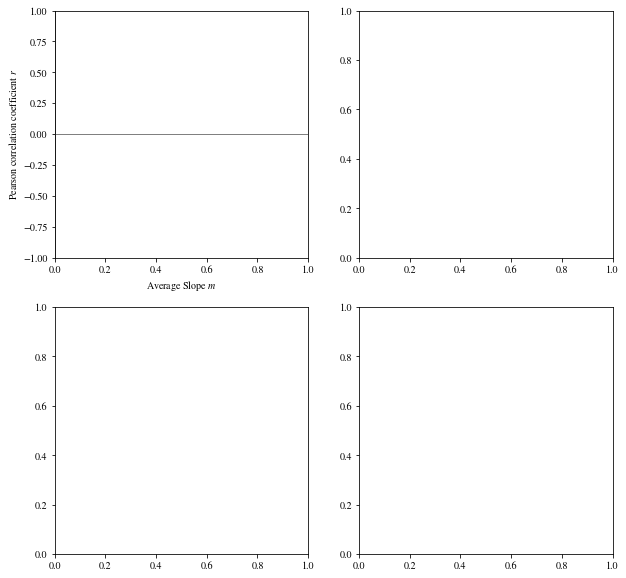

In [26]:
for simbad_name, readable_name in source_names_readable.items():
    fig, ax = plt.subplots(2,2, figsize=(10,10), facecolor='white')
    ax = ax.flatten()
    simbad_name_glob = get_simbad_name_glob(simbad_name)

    for i, xrt_curve in enumerate(['FULL','SOFT','HARD','HR']):
        if xrt_curve=='FULL':
            subset = 'False,True'
        elif xrt_curve!='FULL':
            subset = 'False,False'

        
        ax[i].axvline(0, lw=1.0, color='grey')
        ax[i].axhline(0, lw=1.0, color='grey')
        ax[i].set_ylim(-1,1)

        ax[i].set_xlabel(r'Average Slope $m$')
        ax[i].set_ylabel(r'Pearson correlation coefficient $r$')

        files = glob(f'../lightcurves/correlation_output/*{simbad_name_glob}*/tables/*{xrt_curve}*{subset}*table_corr*')
        for f in files:
            print(f)
            sp = f.split('/')[-1].split(',')
            simbad_name = sp[0]
            xrt_curve   = sp[1]
            uvot_filter = sp[2]
            include_bad = sp[3]
            include_UL  = sp[4]
            
            
            N_obs  = df_prop_idx.loc[simbad_name, xrt_curve, uvot_filter, include_bad, include_UL, 'tab_5_sig']['N_obs']
            N_bad  = df_prop_idx.loc[simbad_name, xrt_curve, uvot_filter, include_bad, include_UL, 'tab_5_sig']['N_bad']
            N_UL   = df_prop_idx.loc[simbad_name, xrt_curve, uvot_filter, include_bad, include_UL, 'tab_5_sig']['N_UL']

            # print(simbad_name, xrt_curve, uvot_filter)

            df = pd.read_csv(f)


            sim_str = f'{uvot_filter}'

            ax[i].set_title(f'XRT:{xrt_curve}   BAD:{include_bad}  UL={include_UL}')
            if N_obs>=20:
                ax[i].scatter(df['m'], df['r'], s=1, color=filter_colors[uvot_filter], rasterized=True, label=f'{uvot_filter} {N_obs}({N_bad}, {N_UL})')
            #ax[i].errorbar(df['m'].mean(), df['r'].mean(), xerr=df['m'].std(), yerr=df['r'].std(), capsize=2.0, lw=2.0)


            lgnd = ax[i].legend(loc='upper left')
            for p in lgnd.legendHandles:
                p._sizes=[30]




    plt.suptitle(f'{readable_name}', size=20)
    plt.savefig(f'../figures/m_r_plots/{simbad_name}_{subset}.pdf', bbox_inches='tight', dpi=300)
    plt.savefig(f'../figures/m_r_plots/{simbad_name}_{subset}.png', bbox_inches='tight', dpi=300)

    plt.show()

    

In [ ]:

df_prop_idx

In [ ]:
simbad_name = 'NAME_Holmberg_IX_X-1'
prop_files = glob(f'../lightcurves/correlation_output/*/tables/*{simbad_name}*prop*')
corr_files = glob(f'../lightcurves/correlation_output/*/tables/*{simbad_name}*corr_mc*')